In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
val_data = datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define input
inputs = Input(shape=(150, 150, 3))

# Define layers explicitly
x = Conv2D(32, (3, 3), activation='relu', name='conv1')(inputs)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu', name='conv2')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

In [11]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = val_dir + '/PNEUMONIA/person1946_bacteria_4874.jpeg'  

img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [15]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


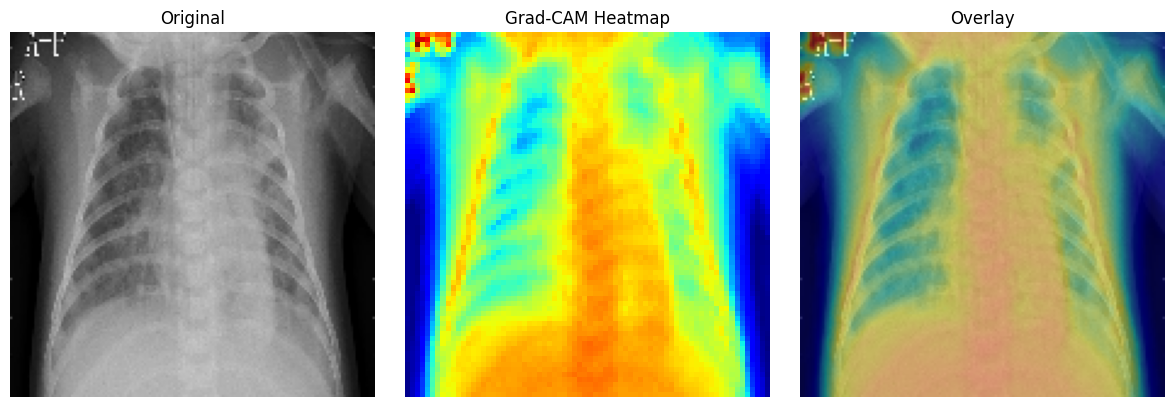

In [17]:
# Use the name of the last Conv2D layer
import matplotlib.pyplot as plt
last_conv_layer_name = 'conv2' 

_ = model.predict(img_array) 

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Superimpose heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

# Display
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()